In [1]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import insightface

In [2]:
dark_video = r"D:\deepfakes\data\test\7489.mp4"
# dark_video2 = r"D:\deepfakes\data\test\4710.mp4"

In [3]:
# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    
    open_cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(open_cv_image, alpha=alpha, beta=beta)
    auto_result = Image.fromarray(auto_result)
    return (auto_result, alpha, beta)

In [4]:
face_detector = insightface.model_zoo.get_model('retinaface_r50_v1')
face_detector.prepare(ctx_id=0, nms=0.4)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


In [6]:
capturator = cv2.VideoCapture(dark_video)
frames_number = int(capturator.get(cv2.CAP_PROP_FRAME_COUNT))
print(frames_number)
width = int(capturator.get(cv2.CAP_PROP_FRAME_WIDTH))
scale = 1.0

frames_list = []

for i in range(frames_number):
    capturator.grab()
    if i % 20 == 0:
        success, frame = capturator.retrieve()
        if not success:
            continue
        
        

        if width <= 300:
            scale = 2.0
        elif 1000 < width <= 1900:
            scale = 0.5
        elif width > 1900:
            scale = 0.33


        bounding_box, _ = face_detector.detect(frame, threshold=0.7, scale=scale)
        if bounding_box.shape[0] == 0:
            continue

        x_min = bounding_box[:, 0]
        y_min = bounding_box[:, 1]
        x_max = bounding_box[:, 2]
        y_max = bounding_box[:, 3]

        areas = (y_max - y_min) * (x_max - x_min)
        max_face_idx = areas.argmax()

        w = x_max[max_face_idx] - x_min[max_face_idx]
        h = y_max[max_face_idx] - y_min[max_face_idx]

        margin_width = w // 4
        margin_height = h // 4

        frame = frame[max(int(y_min[max_face_idx] - margin_height), 0):int(y_max[max_face_idx] + margin_height),
                      max(int(x_min[max_face_idx] - margin_width), 0):int(x_max[max_face_idx] + margin_width)]
        
        transformed_image = Image.fromarray(frame[:, :, ::-1])
        frames_list.append(transformed_image)
#         resized_face = isotropically_resize_image(frame, 224)
#         resized_face = put_to_center(resized_face, 224)
#         transformed_image = Image.fromarray(frame[:, :, ::-1])
#         transformed_image = transformation(transformed_image)
# #         transformed_image = Image.fromarray(frame)
#         transformed.append(transformed_image)

capturator.release()

300


In [7]:
len(frames_list)

15

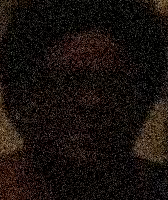

In [8]:
frames_list[0]

In [12]:
auto_result, alpha, beta = automatic_brightness_and_contrast(frames_list[0])
print('alpha', alpha)
print('beta', beta)

alpha 11.590909090909092
beta 0.0


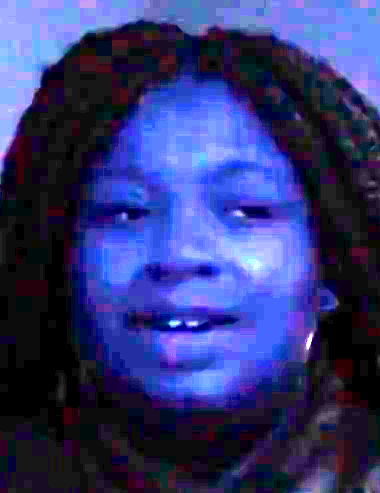

In [13]:
auto_result

In [14]:
def convertScale(img, alpha, beta):
    """Add bias and gain to an image with saturation arithmetics. Unlike
    cv2.convertScaleAbs, it does not take an absolute value, which would lead to
    nonsensical results (e.g., a pixel at 44 with alpha = 3 and beta = -210
    becomes 78 with OpenCV, when in fact it should become 0).
    """

    new_img = img * alpha + beta
    new_img[new_img < 0] = 0
    new_img[new_img > 255] = 255
    return new_img.astype(np.uint8)

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    open_cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = convertScale(open_cv_image, alpha=alpha, beta=beta)
    auto_result = Image.fromarray(auto_result)
    return (auto_result, alpha, beta)

In [15]:
auto_result, alpha, beta = automatic_brightness_and_contrast(frames_list[0])
print('alpha', alpha)
print('beta', beta)

alpha 11.590909090909092
beta 0.0


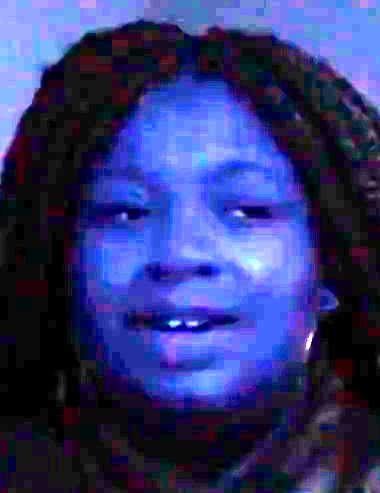

In [16]:
auto_result

In [10]:
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity

In [11]:

img = np.array(frames_list[0]) 
# Convert RGB to BGR 
# img = img[:, :, ::-1].copy() 
yen_threshold = threshold_yen(img)
bright = rescale_intensity(img, (0, yen_threshold), (0, 255))
transformed = Image.fromarray(bright.astype(np.uint8))

In [29]:
np.max(bright)

255.0

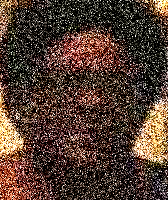

In [12]:
transformed

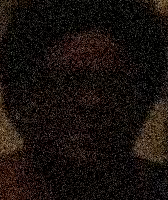

In [13]:
frames_list[0]